In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from src.Graph import GeneGraph 
from src.Function import read_spatial_expression
from src import Preprocess
%matplotlib inline

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def spatial_plot(adata, color):
    sc.set_figure_params(facecolor="white", figsize=(8, 8))
    ax=sc.pl.scatter(adata,alpha=1,x="array_row",y="array_col", color = color, 
                 title=color,show=False,size=500000/adata.shape[0],
                 color_map='bwr')
    ax.set_aspect('equal', 'box')
    ax.axes.invert_yaxis()

In [3]:
dataDir = '../dataset/MOB-breast_cancer/Rep11_MOB_count_matrix-1.tsv'
target_gene = "Myo5a"
locs,data,_=read_spatial_expression(dataDir)
locsDf = pd.DataFrame(locs,columns=['imagerow', 'imagecol'])
locsDf.index = data.index
adata = sc.AnnData(X=data, obs=locsDf)
Preprocess.data_preprocess(adata)

raw data dim: (262, 16218)
Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 3375
Marked 3 spots
Removing genes that are expressed in less than 3 spots with a count of at least 1
Dropped 1559 genes


AnnData object with n_obs × n_vars = 262 × 14659
    obs: 'imagerow', 'imagecol', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p'

In [4]:
# Suppose new_index is your new index
new_index = ["array_row", "array_col"]
adata.obs.rename(columns={"imagerow": new_index[0], "imagecol": new_index[1]}, inplace=True)
adata

AnnData object with n_obs × n_vars = 262 × 14659
    obs: 'array_row', 'array_col', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p'

Graph constructed


100%|██████████| 10/10 [00:00<00:00, 19.38it/s]
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


[[-0.58958001  0.74464618]
 [ 0.58675216  0.55629836]]


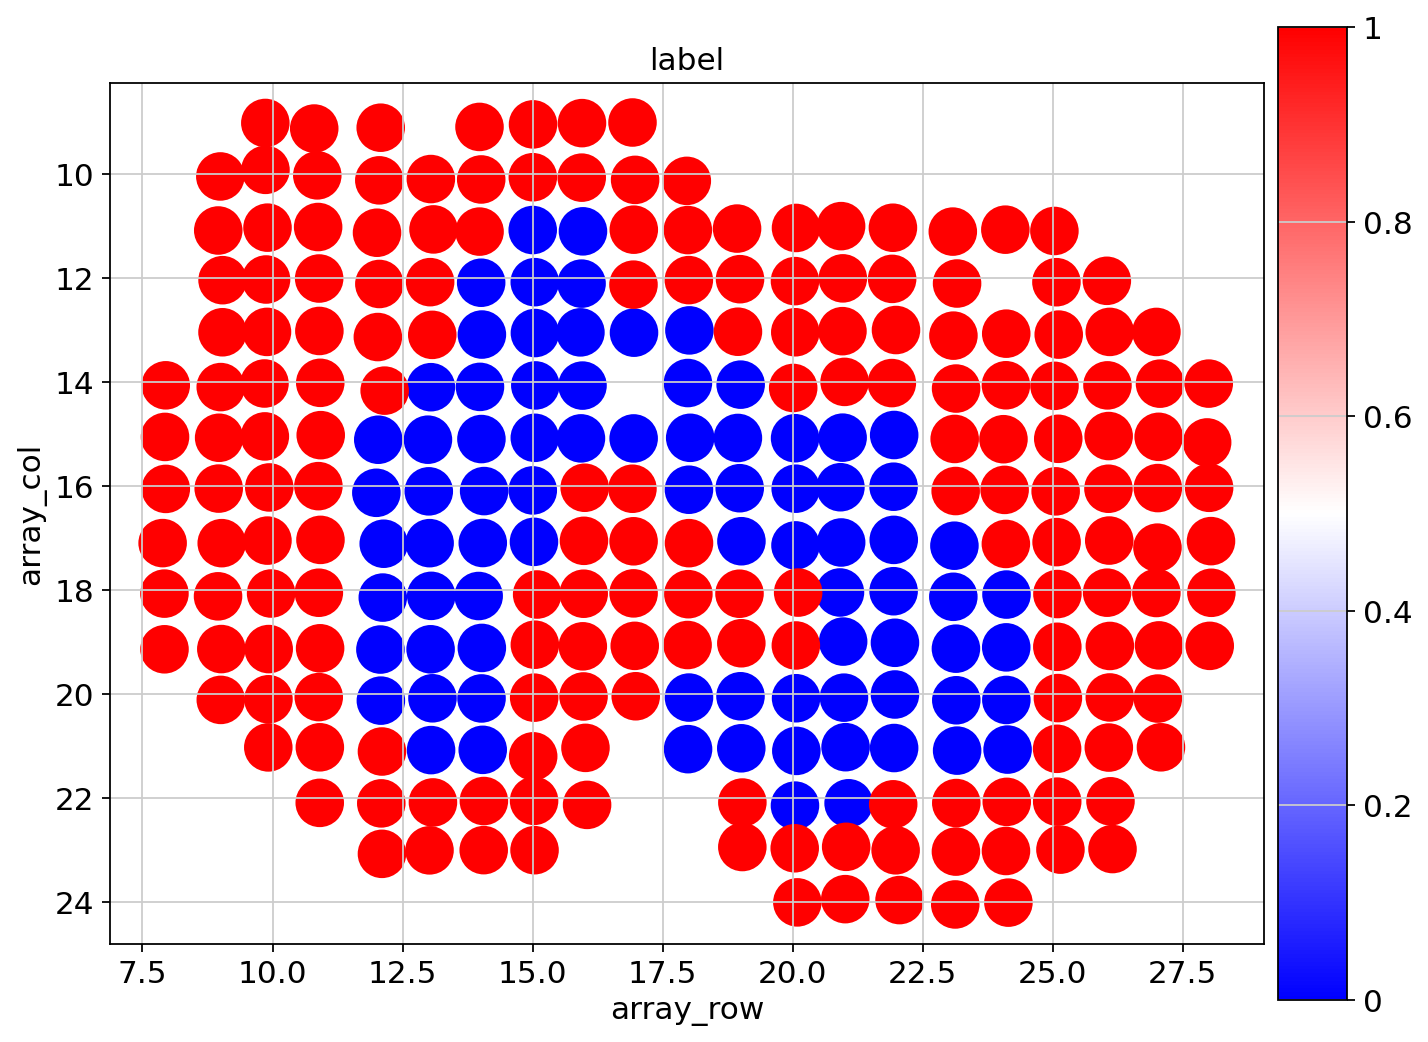

In [7]:
kneighbors,beta = 6,2
geneGraph = GeneGraph(adata, gene_id=target_gene, kneighbors=kneighbors)
geneGraph.mrf_with_icmem(beta = beta)
adata.obs['label'] = geneGraph.label
spatial_plot(adata, 'label')

In [68]:
graph = geneGraph.graph.toarray()
corr = geneGraph.corr
exp = geneGraph.exp
alpha = 0.5 # normalize parameter
theta = 0.5 # decay parameter

In [69]:
corrMatrix = abs(np.multiply(graph, corr)) ## Negative correlation is not considered  here 
corrMatrix = corrMatrix - np.eye(corrMatrix.shape[0]) 

In [70]:
corrMatrix = corrMatrix / (corrMatrix.sum(axis=1).reshape(-1,1) / alpha) # Normalize parameters' choice
adjacencyMatrix = corrMatrix + np.eye(corrMatrix.shape[0])

In [98]:
label = geneGraph.label
labelMatrix = label.reshape(-1,1) == label.reshape(1,-1)
labelMatrix = labelMatrix.astype(float)

In [99]:
labelMatrix[labelMatrix == 0] = theta
labelMatrix

array([[1. , 1. , 1. , ..., 1. , 0.5, 1. ],
       [1. , 1. , 1. , ..., 1. , 0.5, 1. ],
       [1. , 1. , 1. , ..., 1. , 0.5, 1. ],
       ...,
       [1. , 1. , 1. , ..., 1. , 0.5, 1. ],
       [0.5, 0.5, 0.5, ..., 0.5, 1. , 0.5],
       [1. , 1. , 1. , ..., 1. , 0.5, 1. ]])

In [100]:
adjacencyMatrix = np.multiply(adjacencyMatrix, labelMatrix)

In [103]:
imputedExp = np.dot(adjacencyMatrix, exp)

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


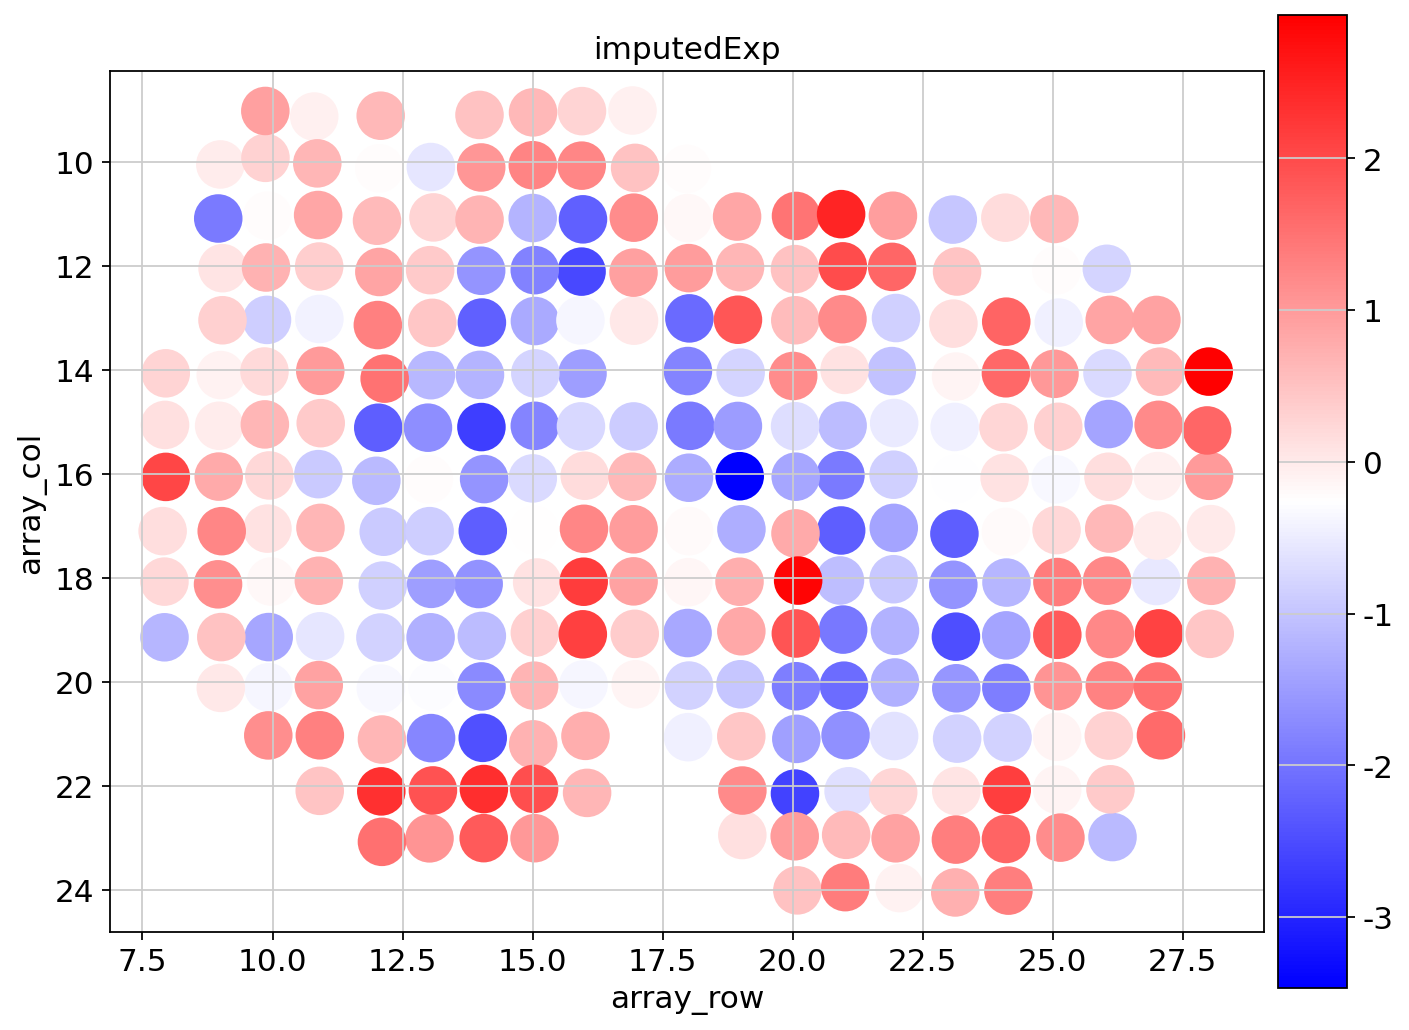

In [104]:
adata.obs['imputedExp'] = imputedExp
spatial_plot(adata, 'imputedExp')